In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pandahouse as ph

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

import orbit
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.backtest import BackTester
from orbit.diagnostics.metrics import mape

import arviz as az

#### Загрузка и первичный анализ данных

In [2]:
connection = {
    'host': 'http://clickhouse.lab.karpov.courses:8123',
    'database':'simulator_20250920',
    'user':'student',
    'password':'dpo_python_2020'
}

Так как цель нашего прогнозирования состоит в том, чтобы решить проблему с подвисанием приложения ввиду высокой активности пользователей, то логично выгружать данные по часам, чтобы заодно понять, в какие часы активность наиболее высокая, и правильно распределить вычислительные мощности.

In [3]:
q = """
    WITH
    new_posts_info AS (
        SELECT
            toString(hour_time) AS hour_time,
            COUNT(post_id) AS new_posts_count
        FROM (
            SELECT
                MIN(toStartOfHour(time)) AS hour_time,
                post_id
            FROM {db}.feed_actions
            GROUP BY post_id
            )
        GROUP BY hour_time
        ),
    main_info AS (
        SELECT
            toString(toStartOfHour(time)) AS hour_time,
            COUNT(DISTINCT user_id) AS DAU,
            SUM(action = 'view') AS views,
            SUM(action = 'like') AS likes,
            likes / views AS ctr,
            COUNT(DISTINCT post_id) AS unique_posts_count
        FROM {db}.feed_actions
        GROUP BY hour_time
        )
    
    SELECT
        main_info.hour_time AS hour_time,
        DAU,
        views,
        likes,
        ctr,
        unique_posts_count,
        new_posts_count
    FROM main_info LEFT JOIN new_posts_info USING(hour_time)
    WHERE toDate(hour_time) <= '2025-10-16' 
    """



data = ph.read_clickhouse(q, connection=connection)
data.head()

,hour_time,DAU,views,likes,ctr,unique_posts_count,new_posts_count
0,2025-09-24 04:00:00,504,7813,1715,0.219506,110,0
1,2025-09-14 12:00:00,1727,20538,4326,0.210634,82,0
2,2025-10-12 10:00:00,2107,33004,6801,0.206066,115,0
3,2025-08-07 02:00:00,102,1300,282,0.216923,85,0
4,2025-08-17 02:00:00,404,7610,1624,0.213403,147,0


In [4]:
data = data.sort_values(by='hour_time')

In [5]:
data['hour_time'].min(), data['hour_time'].max()

('2025-08-06 00:00:00', '2025-10-16 23:00:00')

Видно, что у нас есть данные всего почти за четыре месяца. Будем прогнозировать на неделю вперед.

Нас интересует активность пользователей, значит, наиболее логичный выбор - использовать метрики, которые явно отражают эту активность, например, количество просмотров, количество лайков, DAU. Построим графики изменения во времени всех наших регрессоров. Для этого предварительно агрегируем их по дням.

In [6]:
q = """
    WITH
    new_posts_info AS (
        SELECT
            toString(date) AS date,
            COUNT(post_id) AS new_posts_count
        FROM (
            SELECT
                MIN(toDate(time)) AS date,
                post_id
            FROM {db}.feed_actions
            GROUP BY post_id
            )
        GROUP BY date
        ),
    main_info AS (
        SELECT
            toString(toDate(time)) AS date,
            COUNT(DISTINCT user_id) AS DAU,
            SUM(action = 'view') AS views,
            SUM(action = 'like') AS likes,
            likes / views AS ctr,
            COUNT(DISTINCT post_id) AS unique_posts_count
        FROM {db}.feed_actions
        GROUP BY date
        )
    
    SELECT
        main_info.date AS date,
        DAU,
        views,
        likes,
        ctr,
        unique_posts_count,
        new_posts_count
    FROM main_info LEFT JOIN new_posts_info USING(date)
    WHERE date <= '2025-10-16'
    """



data_daily = ph.read_clickhouse(q, connection=connection)
data_daily.head()

,date,DAU,views,likes,ctr,unique_posts_count,new_posts_count
0,2025-08-06,878,7603,1560,0.205182,89,89
1,2025-08-07,2238,62770,12816,0.204174,178,97
2,2025-08-08,3105,105526,20958,0.198605,191,61
3,2025-08-09,3721,118996,23800,0.200007,211,87
4,2025-08-10,4617,174454,34504,0.197783,214,70


In [7]:
data_daily = data_daily.sort_values(by='date')

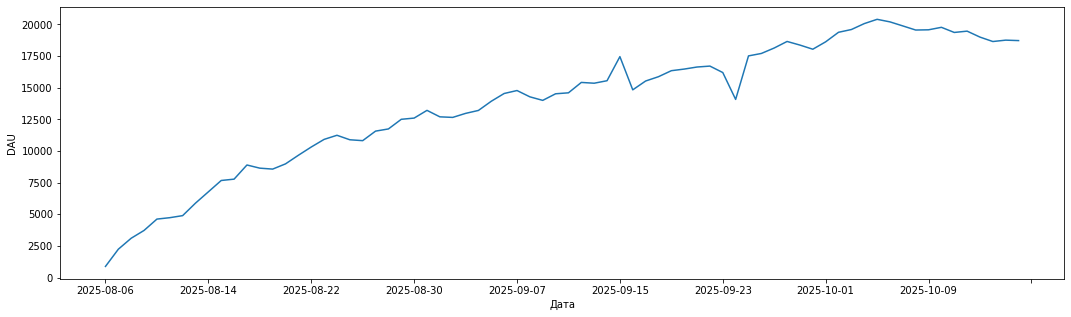

In [8]:
plt.figure(figsize=(18, 5))
plt.plot(data_daily['date'], data_daily['DAU'])
plt.xlabel('Дата')
plt.ylabel('DAU')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(10));

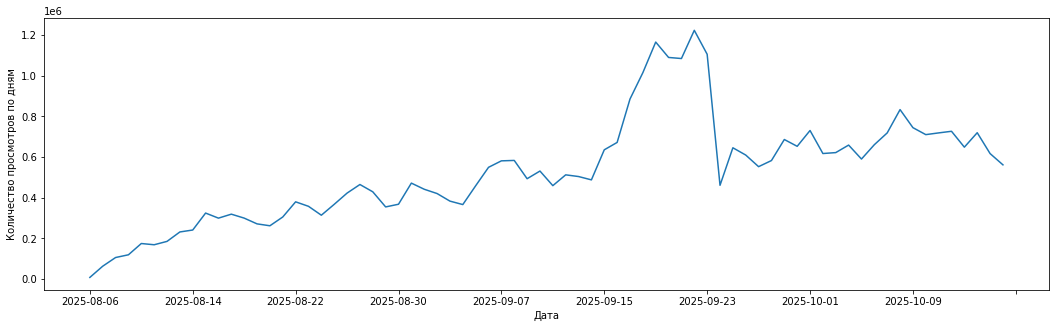

In [64]:
plt.figure(figsize=(18, 5))
plt.plot(data_daily['date'], data_daily['views'])
plt.xlabel('Дата')
plt.ylabel('Количество просмотров по дням')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(10));

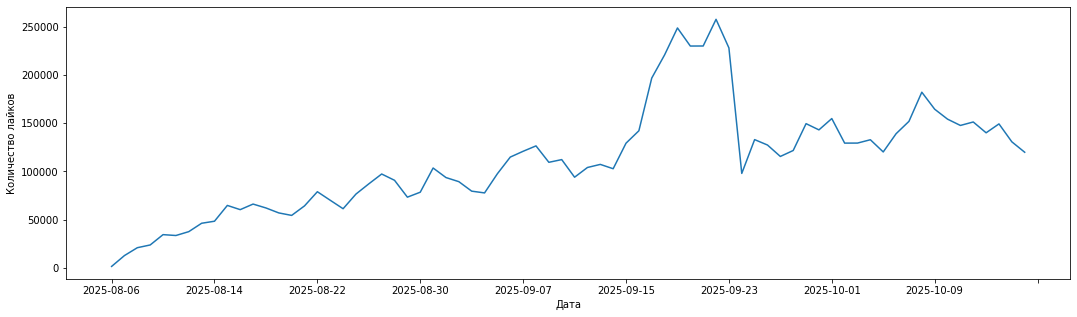

In [10]:
plt.figure(figsize=(18, 5))
plt.plot(data_daily['date'], data_daily['likes'])
plt.xlabel('Дата')
plt.ylabel('Количество лайков')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(10));

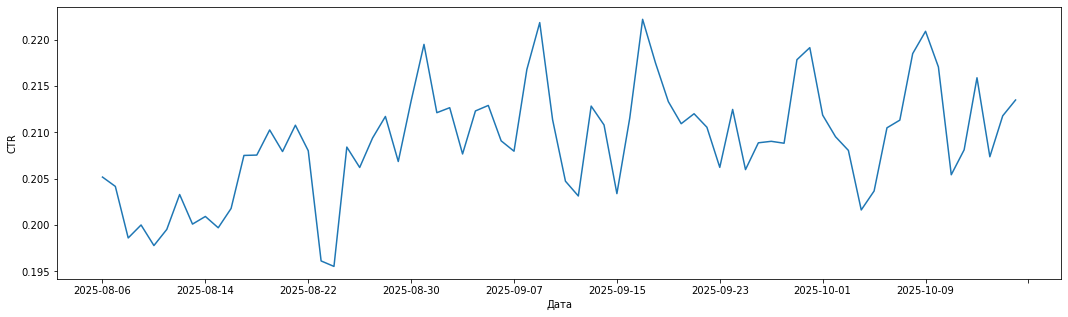

In [11]:
plt.figure(figsize=(18, 5))
plt.plot(data_daily['date'], data_daily['ctr'])
plt.xlabel('Дата')
plt.ylabel('CTR')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(10));

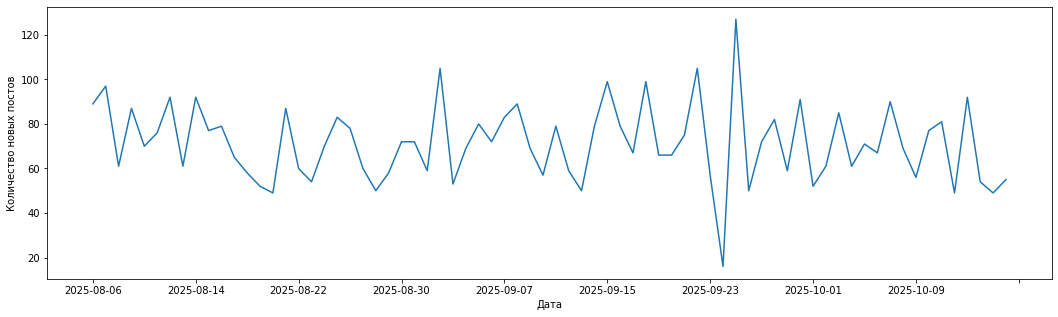

In [12]:
plt.figure(figsize=(18, 5))
plt.plot(data_daily['date'], data_daily['new_posts_count'])
plt.xlabel('Дата')
plt.ylabel('Количество новых постов')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(10));

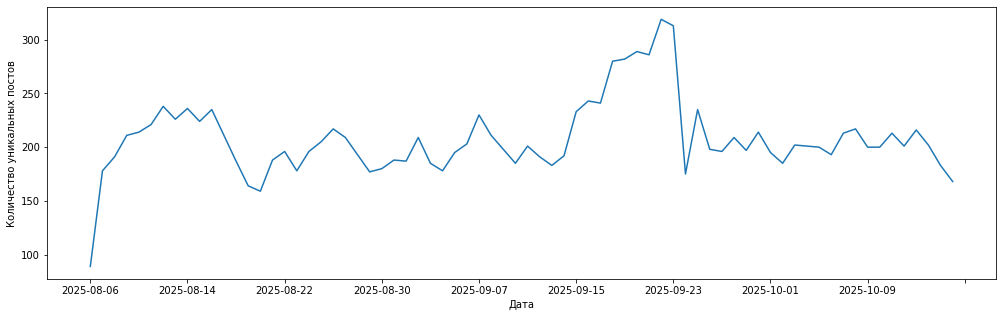

In [13]:
plt.figure(figsize=(17, 5))
plt.plot(data_daily['date'], data_daily['unique_posts_count'])
plt.xlabel('Дата')
plt.ylabel('Количество уникальных постов')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(10));

Из полученных графиков видно, что наиболее чувствительными являются метрики: количество просмотров и количество лайков. Это становится понятным, если обратить внимание на данные за период с 16 по 22 сентября, когда проходил флешмоб (в этот период оба показателя резко увеличились, а после него - вернулись на прежний уровень). Кроме того, эти показатели напрямую связаны с количеством активных пользователей (больше пользователей => больше просмотров и лайков и наоборот). А это означает, что эти метрики наилучшим образом описывают активность пользователей. Будем прогнозировать количество просмотров. Но перед тем как работать с моделями, необходимо будет разобраться с аномалией, вызванной флешмобом, так как она может негативно повлиять на качество прогноза.

Кроме того, очевидно, что в данных есть четко выраженная сезонность, связанная с активностью в разные часы. Посмотрим на количество просмотров по часам за последние несколько дней.

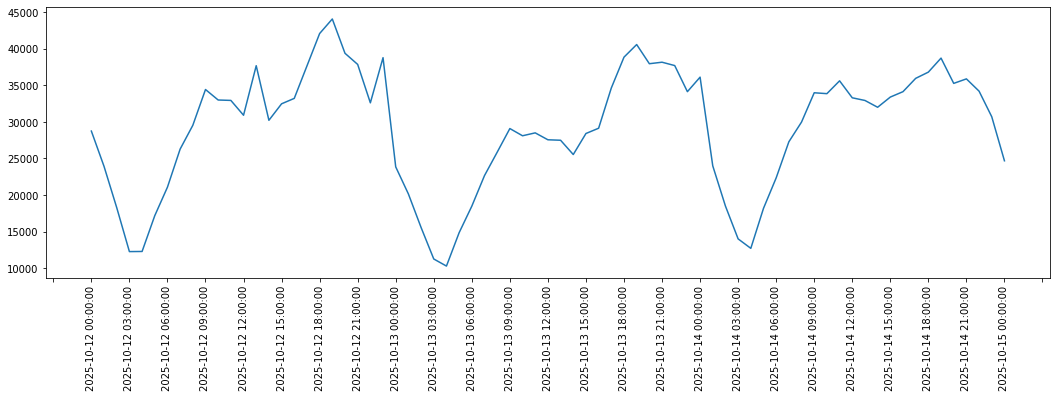

In [14]:
sample = data[data['hour_time'].between('2025-10-12 00:00:00', '2025-10-15 00:00:00')]

plt.figure(figsize=(18, 5))
plt.plot(sample['hour_time'], sample['views'])
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(30));

Видно, что минимальная активность фиксируется около 4 часов утра (по московскому времени), когда регионы с наибольшим числом пользователей (Москва, Санкт-Петербург, Новосибирск и другие) еще спят, далее наблюдается довольно крутой подъем и выход на первый пик в районе 9 часов утра, затем видим небольшой спад в обеденное время, а после - снова рост активности и достижение пика к 19 часам.

#### Построение и валидация модели

Прежде чем приступать к работе с моделями, разберемся с аномалией, вызванной флешмобом, и разделим нашу выборку на тренировочную и тестовую части.

Чтобы сгладить аномалию, сделаем следующее: возьмем данные за 8-15 сентября и данные за 24 сентября - 1 октября и усредним их; далее заменим аномальные данные на получившиеся значения и, тем самым, сгладим этот участок.

In [15]:
data['hour_time'] = pd.to_datetime(data['hour_time'])

In [16]:
sample1 = data.loc[data['hour_time'].between('2025-09-08', '2025-09-16'), 'views']
sample2 = data.loc[data['hour_time'].between('2025-09-24', '2025-10-02'), 'views']
res = (sample1.values + sample2.values) / 2

In [17]:
data.loc[data['hour_time'].between('2025-09-16', '2025-09-24'), 'views'] = res

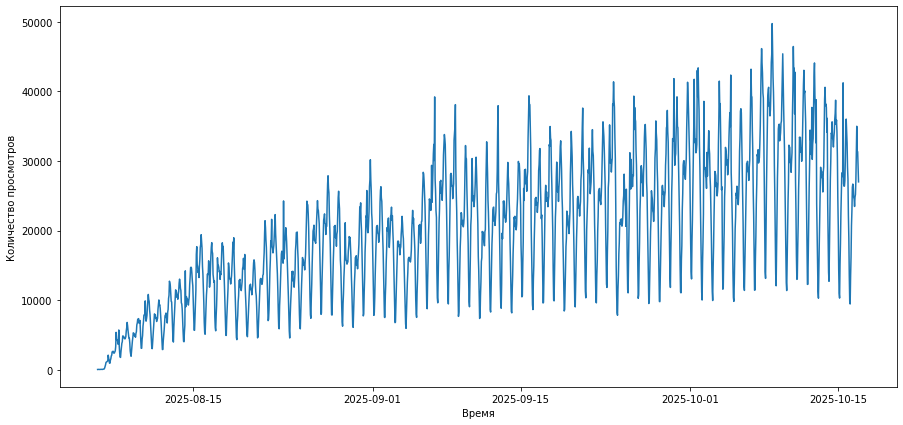

In [18]:
plt.figure(figsize=(15, 7))
plt.plot(data['hour_time'], data['views'])
plt.xlabel('Время')
plt.ylabel('Количество просмотров')
plt.show()

In [19]:
data['hour_time'].max(), data['hour_time'].max() - pd.Timedelta(days=7)

(Timestamp('2025-10-16 23:00:00'), Timestamp('2025-10-09 23:00:00'))

Теперь разделим данные на тренировочную и тестовую выборки.

In [20]:
train = data[data['hour_time'] <= (data['hour_time'].max() - pd.Timedelta(days=7))]
test = data[data['hour_time'] > (data['hour_time'].max() - pd.Timedelta(days=7))]

Построим модель. Для начала будем использовать алгоритм MAP, так как он обладает более высокой скоростью.

In [21]:
dlt = DLT(
    seasonality=24,
    response_col="views",
    date_col="hour_time",
    estimator='stan-map',
    num_warmup=2000,  # время "разогрева"
    num_sample=1000  # время сэмплирования
)

2025-12-01 11:08:18 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


Для сравнения попробуем оба варианта бэктестера: расширяющийся и скользящий. Начнем с расширяющегося.

In [22]:
bt_exp = BackTester(
    model=dlt,
    df=train[['hour_time', 'views']],
    min_train_len=24*7,
    incremental_len=24*7,
    forecast_len=24*7,
    window_type="expanding"
)

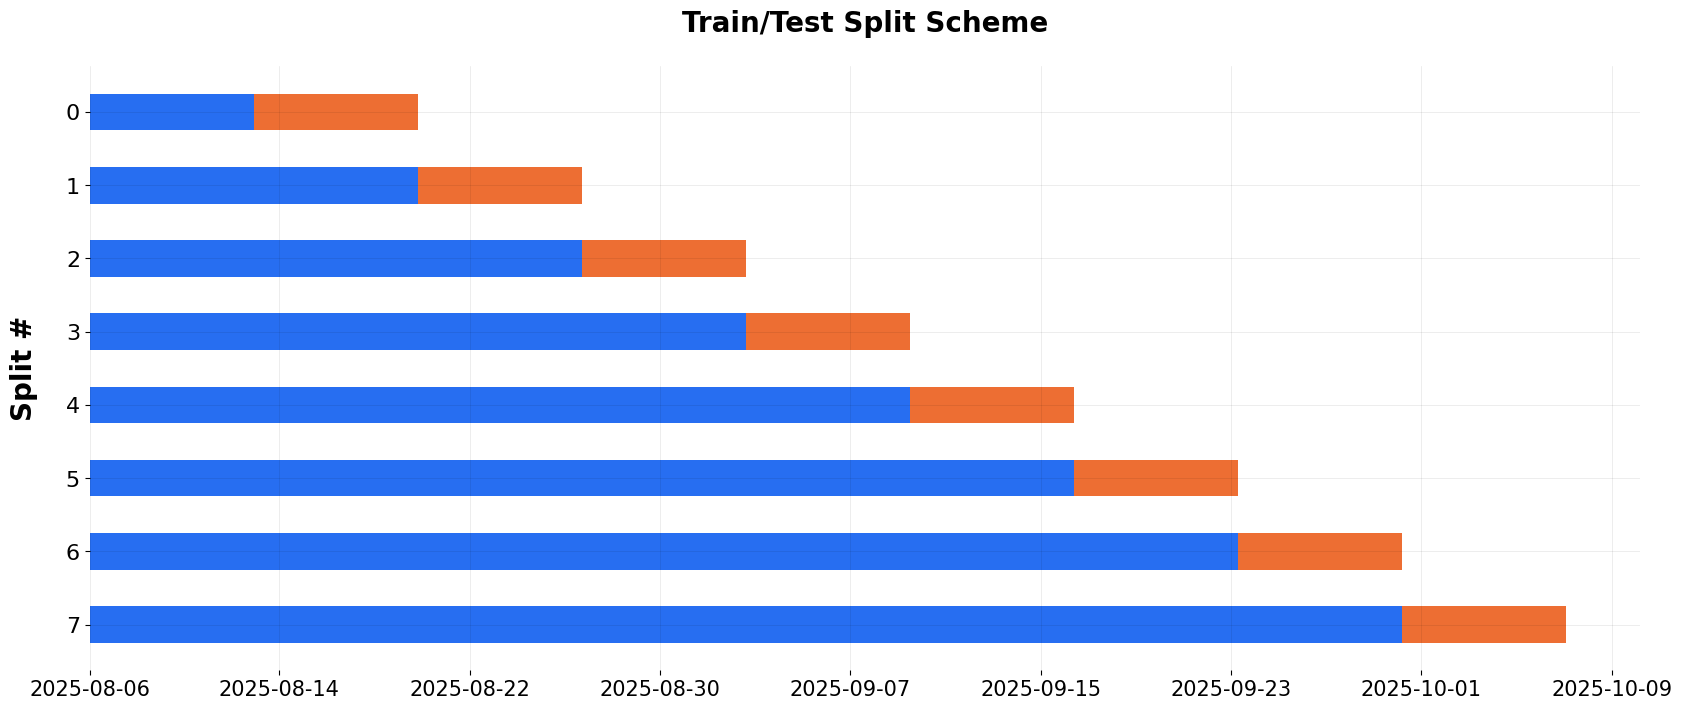

In [23]:
bt_exp.plot_scheme()

In [24]:
bt_exp.fit_predict()
bt_exp.score()

,metric_name,metric_values,is_training_metric
0,smape,2.041554e-01,False
1,wmape,1.754439e-01,False
2,mape,1.994738e-01,False
3,mse,1.908189e+07,False
4,mae,3.557920e+03,False
5,rmsse,1.535240e+00,False


In [25]:
bt_roll = BackTester(
    model=dlt,
    df=train[['hour_time', 'views']],
    min_train_len=2*24*7,
    incremental_len=24*7,
    forecast_len=24*7,
    window_type="rolling"
)

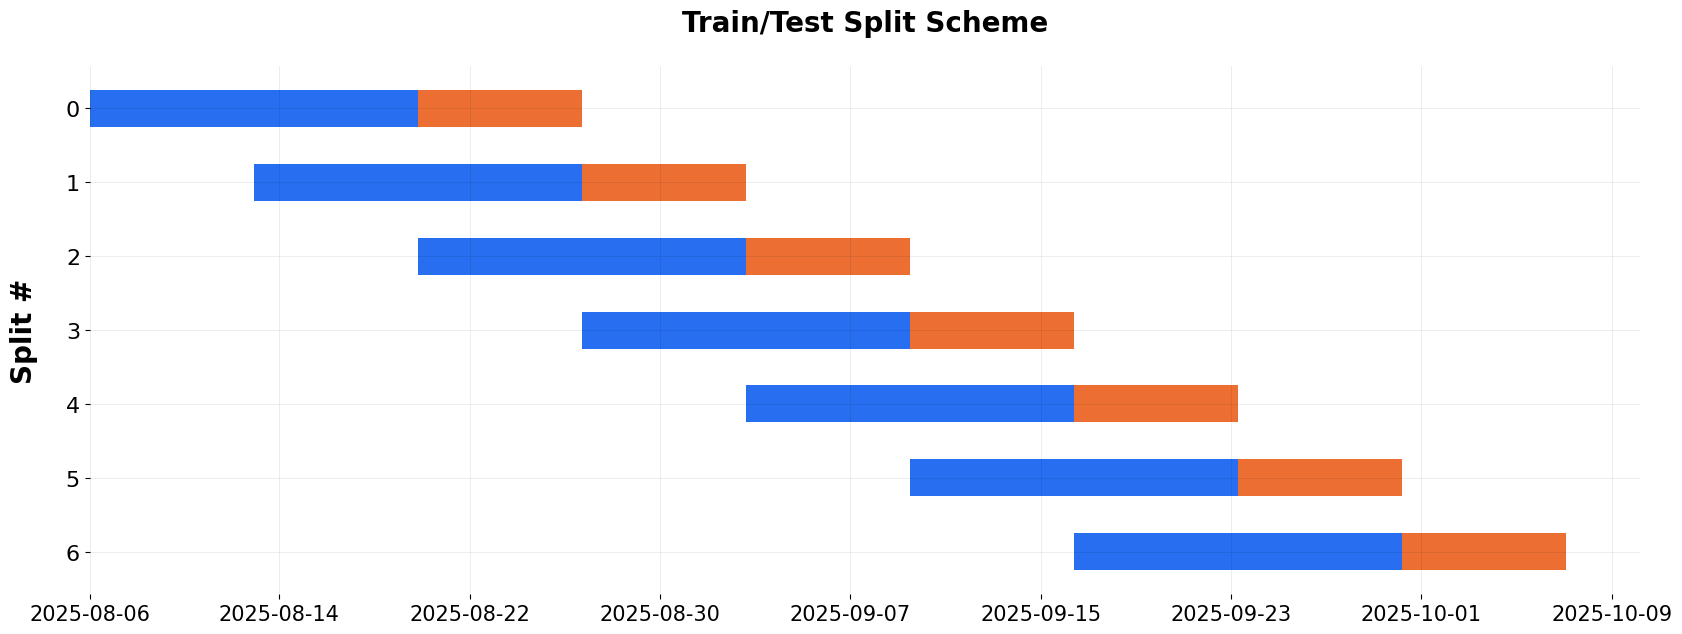

In [26]:
bt_roll.plot_scheme()

In [27]:
bt_roll.fit_predict()
bt_roll.score()

,metric_name,metric_values,is_training_metric
0,smape,1.516011e-01,False
1,wmape,1.460899e-01,False
2,mape,1.573421e-01,False
3,mse,1.596600e+07,False
4,mae,3.139153e+03,False
5,rmsse,1.346340e+00,False


Теперь попробуем изменить алгоритм прогнозирования на MCMC.

In [28]:
dlt_mcmc = DLT(
    seasonality=24,
    response_col="views",
    date_col="hour_time", 
    estimator='stan-mcmc',
    num_warmup=2000,  # время "разогрева"
    num_sample=1000  # время сэмплирования
)

In [29]:
bt_exp_mcmc = BackTester(
    model=dlt_mcmc,
    df=train[['hour_time', 'views']],
    min_train_len=24*7,
    incremental_len=24*7,
    forecast_len=24*7,
    window_type="expanding"
)

In [30]:
bt_exp_mcmc.fit_predict()
bt_exp_mcmc.score()

2025-12-01 11:08:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:08:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:08:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:09:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:10:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:10:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:12:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:13:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric
0,smape,2.119051e-01,False
1,wmape,1.791878e-01,False
2,mape,2.030035e-01,False
3,mse,2.068435e+07,False
4,mae,3.633845e+03,False
5,rmsse,1.598404e+00,False


In [31]:
bt_roll = BackTester(
    model=dlt_mcmc,
    df=train[['hour_time', 'views']],
    min_train_len=2*24*7,
    incremental_len=24*7,
    forecast_len=24*7,
    window_type="rolling"
)

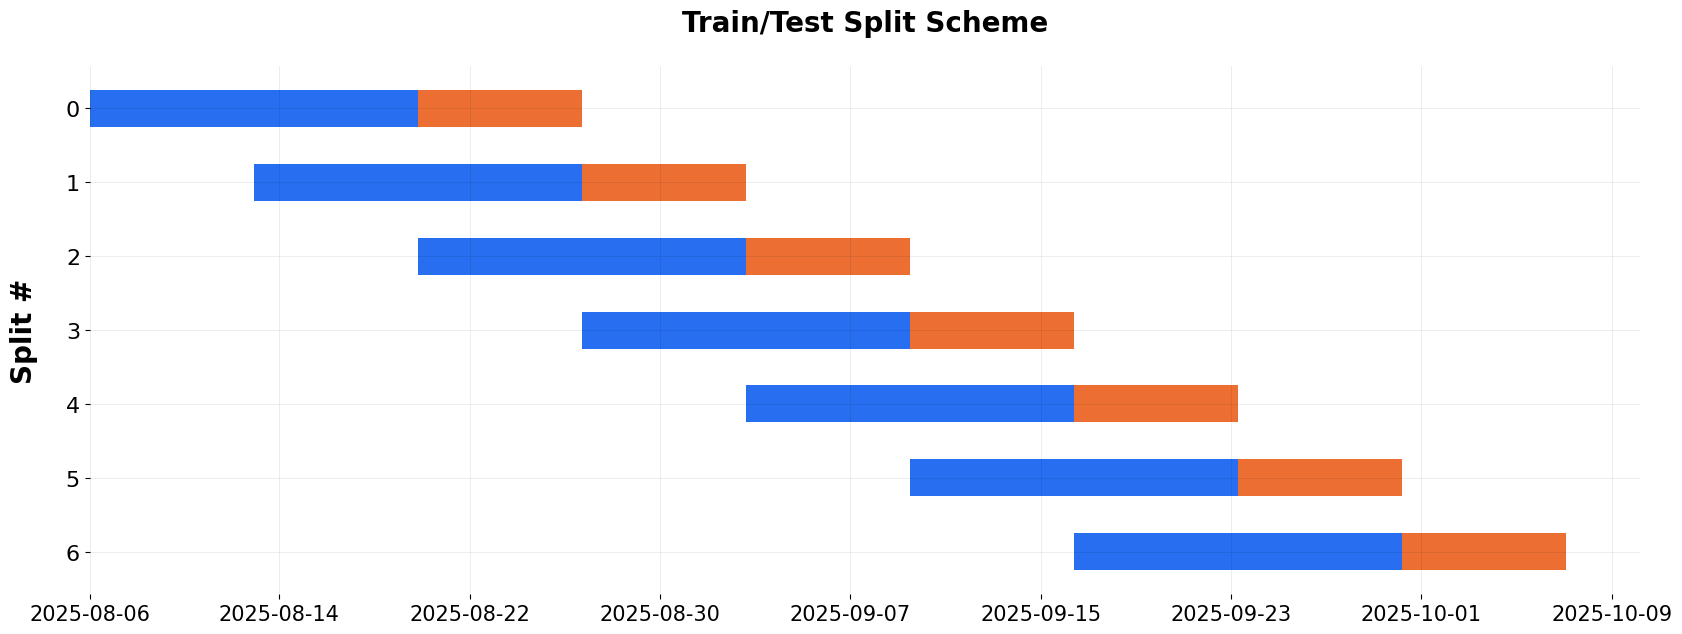

In [32]:
bt_roll.plot_scheme()

In [33]:
bt_roll.fit_predict()
bt_roll.score()

2025-12-01 11:14:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:15:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:15:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:15:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:16:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:16:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:16:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric
0,smape,1.690586e-01,False
1,wmape,1.537576e-01,False
2,mape,1.728266e-01,False
3,mse,1.696542e+07,False
4,mae,3.303916e+03,False
5,rmsse,1.387838e+00,False


После экспериментов с длительностью тренировочного набора я пришел к выводу, что - оптимальный размер обучающего окна - 2 недели. В этом случае значения метрик даже лучше, чем при использовании расширяющегося окна. Это говорит о том, что наиболее важная часть тренировочных данных - это две прошедшие недели. При этом вне зависимости от используемого типа окна алгоритм MAP показывает более хорошие результаты, чем алгоритм MCMC.

Кроме того, интересно попробовать добавить в модели регрессор, так как потенциально это должно увеличить каччество прогноза. В качестве регрессора можно выбрать почасовой аналог DAU, так как число активных пользователей достаточно сильно влияет на количество просмотров. Значения этого регрессора хранятся в колонке с названием DAU. Однако в этом случае нам придется сначала предсказывать значение регрессора, а уже потом использовать их для получения прогноза целевой переменной.

In [34]:
dlt_dau = DLT(
    seasonality=24,
    response_col="DAU",
    date_col="hour_time",
    estimator='stan-map',
    num_warmup=2000,  # время "разогрева"
    num_sample=1000  # время сэмплирования
)

2025-12-01 11:17:07 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [35]:
dlt_dau.fit(train[['hour_time', 'DAU']])

In [36]:
predicted_dau = dlt_dau.predict(df=test[['hour_time']])
predicted_dau.head()

,hour_time,prediction
0,2025-10-10 00:00:00,1395.773580
1,2025-10-10 01:00:00,1181.107758
2,2025-10-10 02:00:00,915.754937
3,2025-10-10 03:00:00,651.983115
4,2025-10-10 04:00:00,647.819293


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

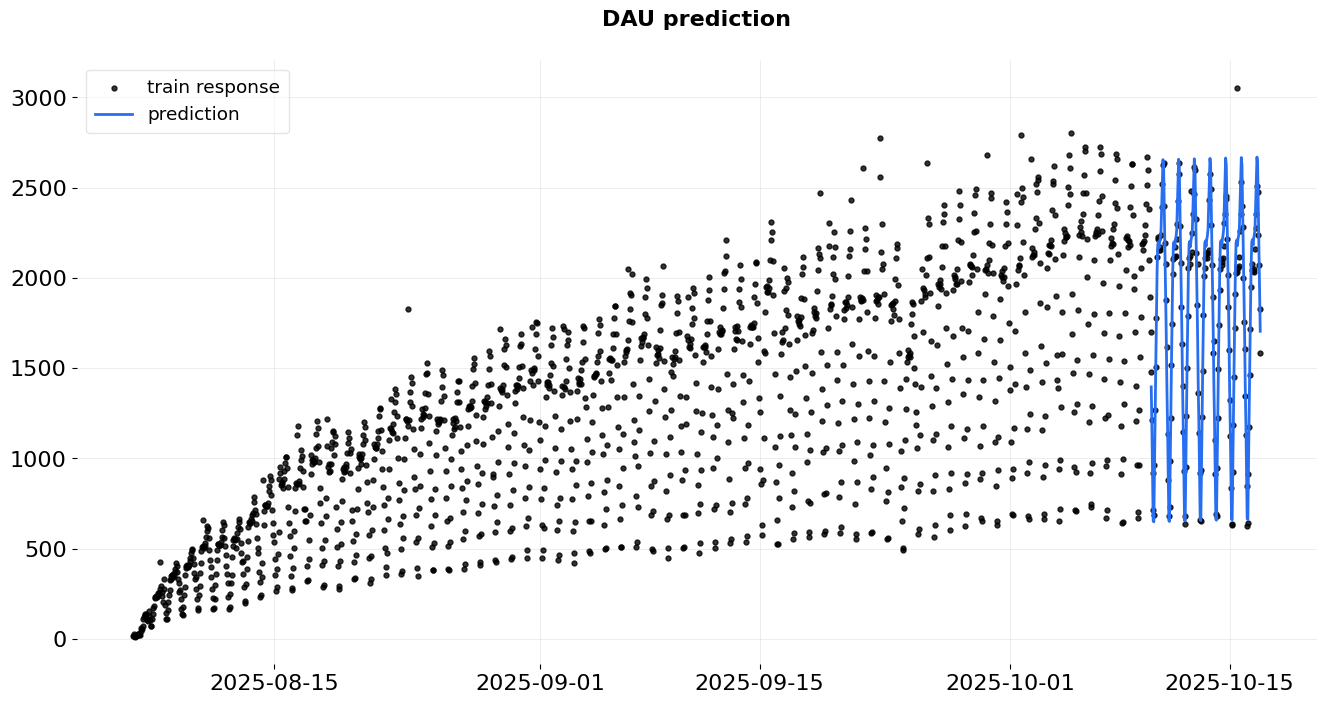

In [37]:
_ = plot_predicted_data(data[['hour_time', 'DAU']], predicted_dau, 'hour_time', 'DAU', title='DAU prediction')

In [38]:
test['DAU_predicted'] = predicted_dau['prediction'].values

In [39]:
test.head()

,hour_time,DAU,views,likes,ctr,unique_posts_count,new_posts_count,DAU_predicted
317,2025-10-10 00:00:00,1480,26736.0,6142,0.229728,128,5,1395.773580
1309,2025-10-10 01:00:00,1212,22534.0,5205,0.230984,129,1,1181.107758
474,2025-10-10 02:00:00,921,16323.0,3834,0.234883,123,0,915.754937
199,2025-10-10 03:00:00,713,12468.0,2854,0.228906,123,0,651.983115
1480,2025-10-10 04:00:00,685,11365.0,2560,0.225253,119,0,647.819293


In [40]:
test = test.rename(columns={'DAU': 'DAU_true', 'DAU_predicted': 'DAU'})

In [41]:
mape(test['DAU_true'], test['DAU'])

0.04683491762929768

In [42]:
train.head()

,hour_time,DAU,views,likes,ctr,unique_posts_count,new_posts_count
481,2025-08-06 00:00:00,14,15.0,7,0.466667,1,1
1051,2025-08-06 01:00:00,26,28.0,4,0.142857,2,1
1010,2025-08-06 02:00:00,16,19.0,5,0.263158,2,0
235,2025-08-06 03:00:00,11,11.0,0,0.000000,2,0
1234,2025-08-06 04:00:00,14,16.0,2,0.125000,2,0


In [43]:
for col in data.select_dtypes('uint64').columns:
    data[col] = data[col].astype('int64')
    train[col] = train[col].astype('int64')
    test[col] = test[col].astype('int64')

In [44]:
dlt_regr = DLT(
    seasonality=24,
    response_col="views",
    date_col="hour_time",
    estimator='stan-map',
    num_warmup=2000,
    num_sample=1000,
    regressor_col=['DAU']
)

2025-12-01 11:17:08 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [45]:
bt_exp = BackTester(
    model=dlt_regr,
    df=train[['hour_time', 'views', 'DAU']],
    min_train_len=24*7,
    incremental_len=24*7,
    forecast_len=24*7,
    window_type="expanding"
)

In [46]:
bt_exp.fit_predict()
bt_exp.score()

,metric_name,metric_values,is_training_metric
0,smape,1.658938e-01,False
1,wmape,1.479726e-01,False
2,mape,1.591957e-01,False
3,mse,1.478480e+07,False
4,mae,3.000815e+03,False
5,rmsse,1.351367e+00,False


In [47]:
dlt_mcmc_regr = DLT(
    seasonality=24,
    response_col="views",
    date_col="hour_time", 
    estimator='stan-mcmc',
    num_warmup=2000,
    num_sample=1000,
    regressor_col=['DAU']
)

In [48]:
bt_exp_mcmc = BackTester(
    model=dlt_mcmc_regr,
    df=train[['hour_time', 'views', 'DAU']],
    min_train_len=24*7,
    incremental_len=24*7,
    forecast_len=24*7,
    window_type="expanding"
)

In [49]:
bt_exp_mcmc.fit_predict()
bt_exp_mcmc.score()

2025-12-01 11:17:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:17:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:17:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:18:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:18:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:19:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:21:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-12-01 11:22:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric
0,smape,1.542002e-01,False
1,wmape,1.397752e-01,False
2,mape,1.487872e-01,False
3,mse,1.366964e+07,False
4,mae,2.834576e+03,False
5,rmsse,1.299404e+00,False


#### Выбор лучшей модели, итоговое тестирование и интерпретация результатов прогнозирования

По итогам тестирования было выявлено, что лучшие результаты были достигнуты при использовании алгоритма MCMC с дополнительным регрессором и бэктестером с расширяющимся окном. Проведем итоговое тестирование модели.

In [50]:
dlt_mcmc_regr = DLT(
    seasonality=24,
    response_col="views",
    date_col="hour_time", 
    estimator='stan-mcmc',
    num_warmup=2000,
    num_sample=2000,
    regressor_col=['DAU']
)

In [51]:
dlt_mcmc_regr.fit(train[['hour_time', 'views', 'DAU']])

2025-12-01 11:24:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [52]:
dlt_mcmc_regr_pred = dlt_mcmc_regr.predict(test[['hour_time', 'DAU']], decompose=True)
dlt_mcmc_regr_pred.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-10-10 00:00:00,23963.896632,25558.617060,27068.235859,2464.487605,4373.272513,6121.923592,3509.25500,3981.4050,4445.2505,16689.647475,17204.6745,17707.020975
1,2025-10-10 01:00:00,19726.957834,21717.106743,23682.281481,2087.858922,4371.817886,6461.052607,2304.31700,2807.7650,3327.9585,14129.371805,14565.3911,14990.675105
2,2025-10-10 02:00:00,13134.392207,15588.766864,17949.974005,1741.560455,4298.644071,6878.267308,-577.87885,-17.0091,566.8783,10946.973075,11284.7865,11614.282575
3,2025-10-10 03:00:00,7708.717107,10461.035897,13239.329297,1353.914254,4275.701254,7213.118860,-2428.22350,-1795.4650,-1127.7835,7788.502155,8028.8481,8263.276455
4,2025-10-10 04:00:00,6461.613776,9482.191802,12586.909594,1157.420414,4219.006122,7408.934406,-3335.48200,-2702.2100,-2034.4995,7740.646535,7979.5157,8212.503635


In [53]:
mape(test['views'].reset_index(drop=True), dlt_mcmc_regr_pred['prediction'])

0.11458922801083539

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

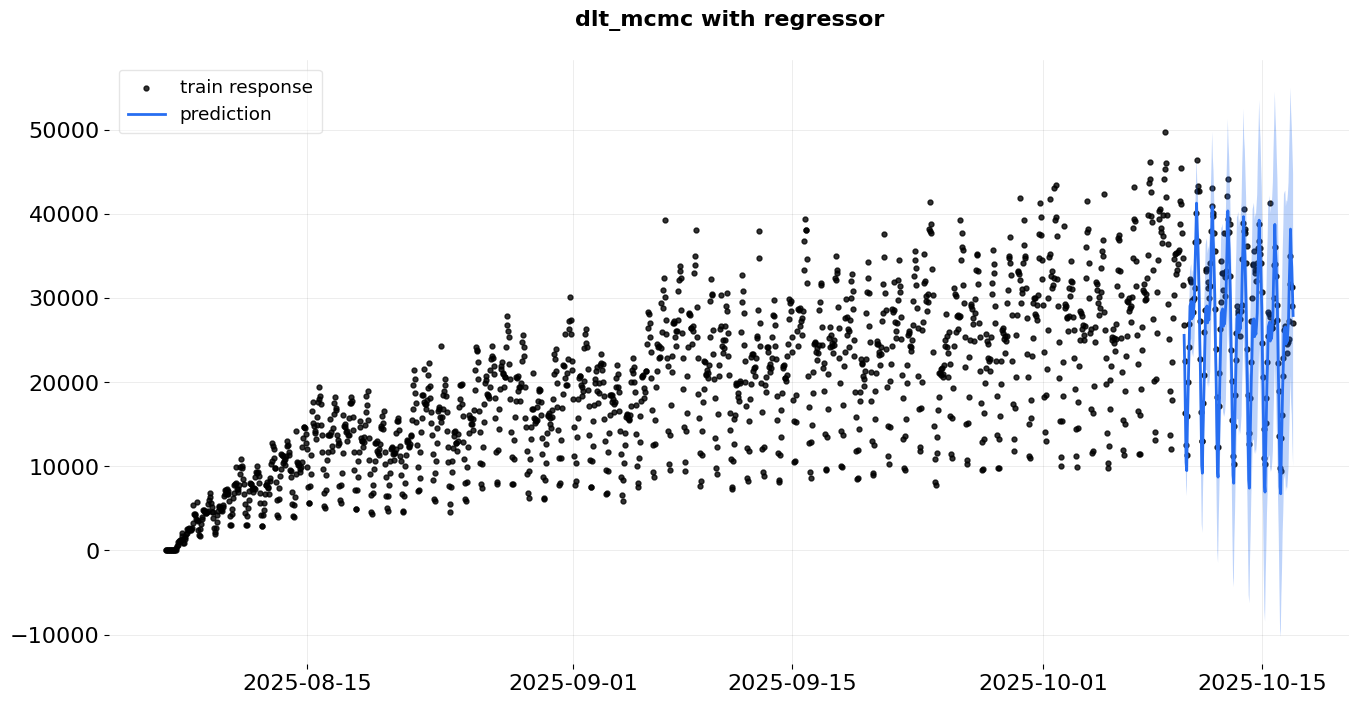

In [54]:
_ = plot_predicted_data(data[['hour_time', 'views']], dlt_mcmc_regr_pred, 'hour_time', 'views', title='dlt_mcmc with regressor')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

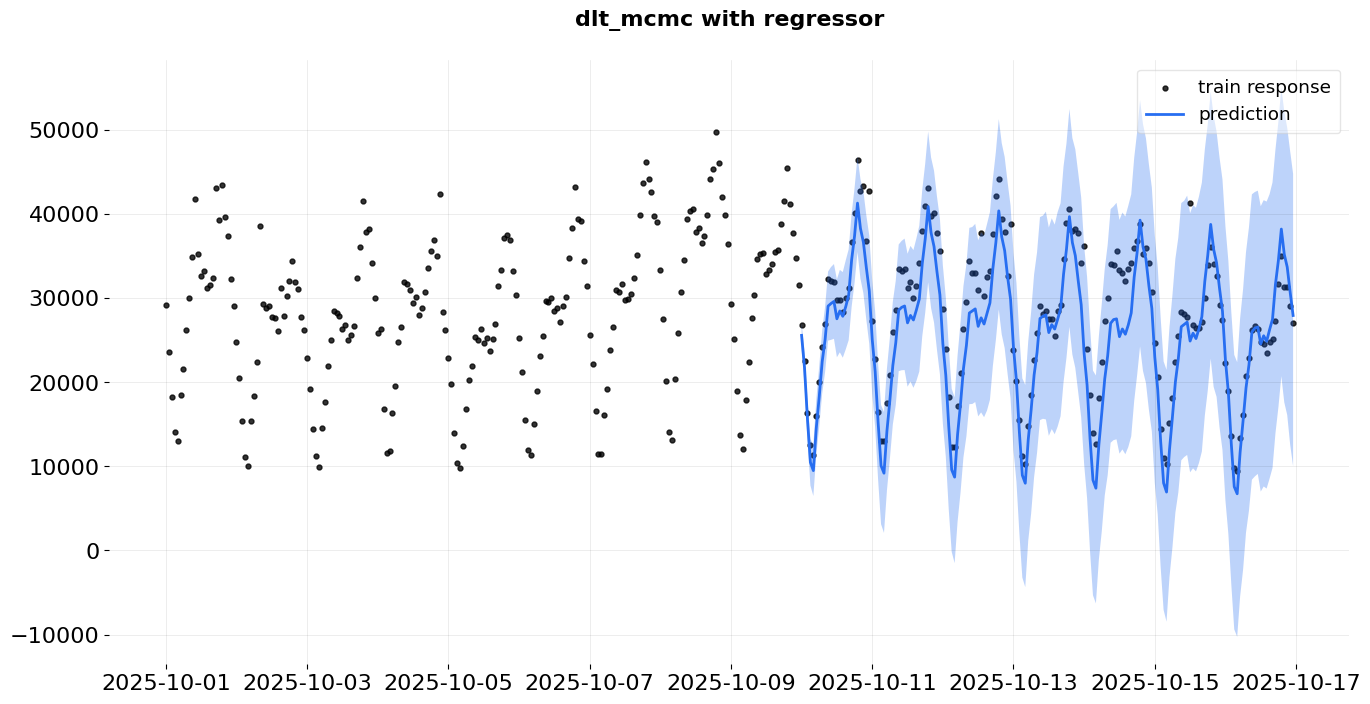

In [57]:
data_part = data.loc[data['hour_time'] >= '2025-10-01', ['hour_time', 'views']]
pred_part = dlt_mcmc_regr_pred.loc[dlt_mcmc_regr_pred['hour_time'] >= '2025-10-01']

_ = plot_predicted_data(data_part, pred_part, 'hour_time', 'views', title='dlt_mcmc with regressor')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

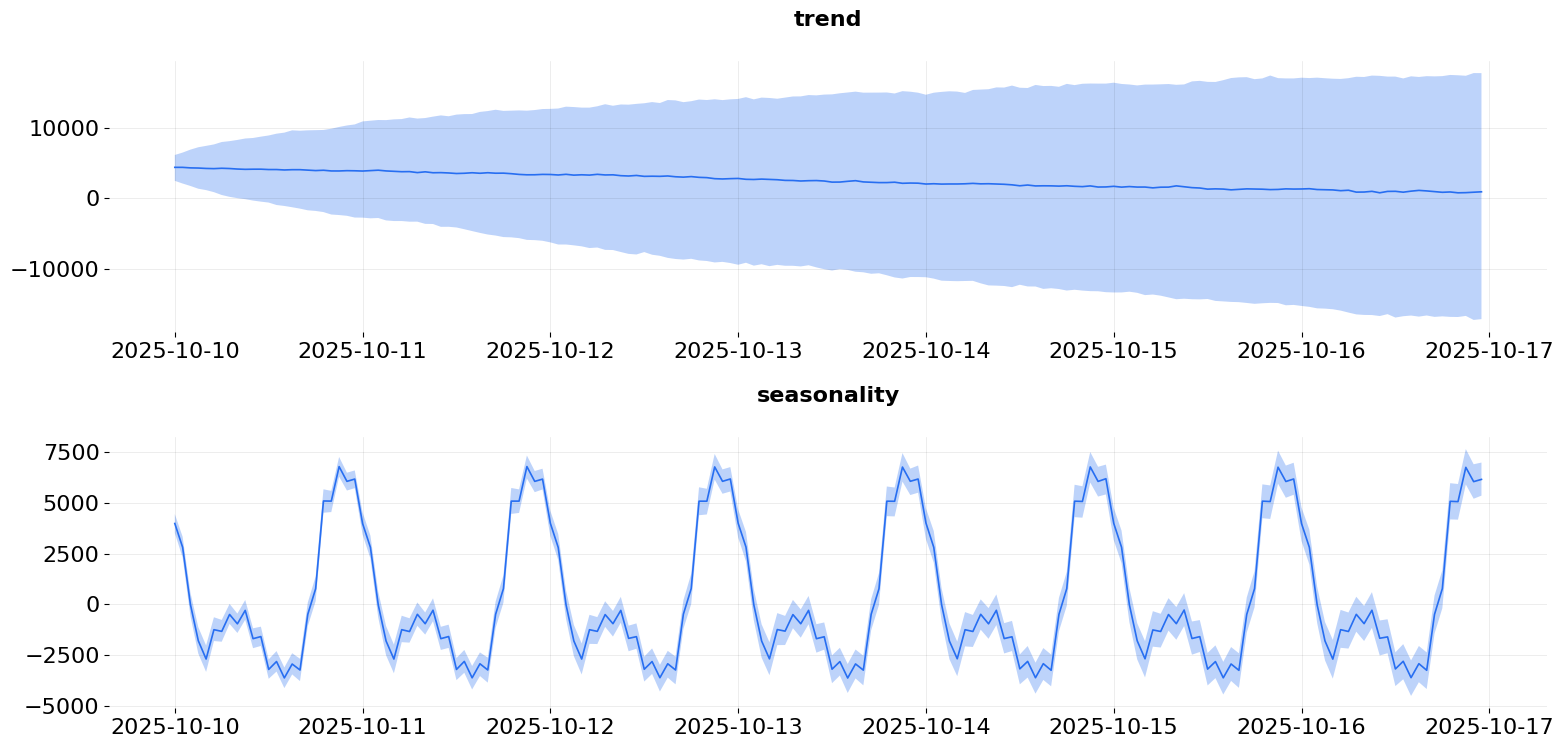

In [58]:
_ = plot_predicted_components(dlt_mcmc_regr_pred, "hour_time", plot_components=['trend', 'seasonality'])

In [59]:
dlt_mcmc_regr_pred['date'] = dlt_mcmc_regr_pred['hour_time'].dt.date
daily_views_pred = dlt_mcmc_regr_pred.groupby('date', as_index=False)['prediction'].sum()

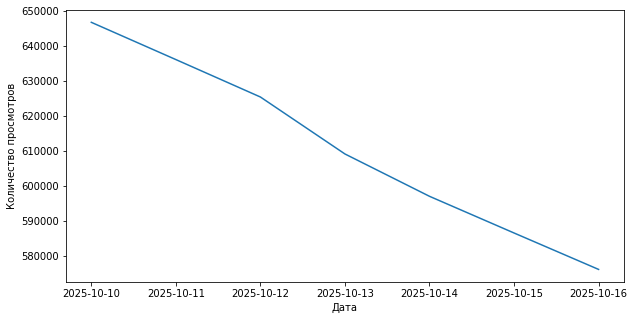

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(daily_views_pred['date'], daily_views_pred['prediction'])
plt.xlabel('Дата')
plt.ylabel('Количество просмотров');

In [61]:
params = dlt_mcmc_regr.get_posterior_samples(permute=False)  # достаём информацию о параметрах
params.keys()  # их названия

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'beta', 'gt_sum', 'gb', 'gl', 'loglk'])

In [62]:
params["obs_sigma"].shape  # смотрим те, у которых третьего измерения либо нет, либо оно равно 1

(4, 500)

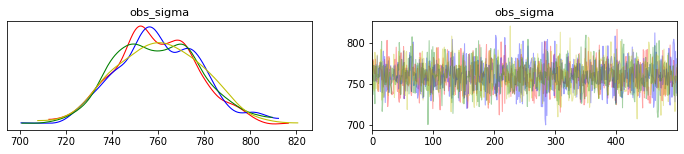

In [63]:
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma");

Видно, что MCMC с регрессором показывает лучший результат. Кроме того, эта модель прошла проверку на сходимость и показала адекватные доверительные интервалы.

Что касается самих результатов прогнозирования. В ближайшую неделю ожидается спад количества просмотров примерно в 1,12 раза (с 650 тыс. до 580 тыс. с 90%-ным доверительным интервалом до <u>+</u> 40%). Это, в свою очередь, означает, что активность пользователей и, как следствие, нагрузка на приложение снизятся.